In [1]:
from pyspark.sql import SparkSession

# Create a spark session (which will run spark jobs)
spark = (
    SparkSession.builder.appName("MAST30034_Yellow_Taxi_Build_Model_Eval")
    .config("spark.sql.repl.eagerEval.enabled", True)
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.executor.memory", "2g")
    .config("spark.driver.memory", "4g")
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .getOrCreate()
)

22/08/22 20:26:13 WARN Utils: Your hostname, LAPTOP-VAB0S7AL resolves to a loopback address: 127.0.1.1; using 172.27.226.71 instead (on interface eth0)
22/08/22 20:26:13 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
22/08/22 20:26:15 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/08/22 20:26:15 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [2]:
# Change for full model or subsample
#subsample = True
subsample = False

In [3]:
# read in cleaned 2019 taxi+weather data & confirm
sdf = spark.read.parquet('../data/curated/yt2019_cleaned.parquet')

In [4]:
#sdf.limit(5)

In [5]:
model_features = ['VendorID', 'passenger_count','trip_distance','RatecodeID', 'PULocationID', 'DOLocationID', 'payment_type',
                  'congestion_surcharge', 'PU_hourofday','DO_hourofday','PU_dayofweek','DO_dayofweek','PU_dayofmonth',
                  'PU_month','DO_month','trip_time_minutes','trip_speed_mph','tmpf','dwpf','relh']

In [ ]:
# chosen subset of features used in modelling
sdf.columns

### Pipeline

In [ ]:
from model import build_pipeline, build_pipeline_rf, get_evaluator, train_model

In [ ]:
# in development use subsampled training set, else use full (2019 NYC Yellow Taxi Data)
print("full dataset counts: " + str(sdf.count()))
# TODO: can remove this
if subsample:
    train = sdf.sample(fraction=0.005, seed=0)
    print("subsampled dataset counts: " + str(train.count()))
else:
   train = sdf

Build the pipeline, train the model and export

In [ ]:
# Get pipeline obj
pipeline = build_pipeline(model_features)
pipeline_rf = build_pipeline_rf(model_features)

In [ ]:
# train the model on the dataset
model = train_model(train, pipeline) #GBT

In [ ]:
model2 = train_model(train, pipeline_rf) #RF

Save the model locally

In [ ]:
# save the model -> cross machine reqires removal of .src files!
from pyspark.ml.util import MLWriter
if subsample:
    model.write().overwrite().save('../models/GBTModel_2019_subsampled')
else:
    model.write().overwrite().save('../models/GBTModel_2019')

In [ ]:
if subsample:
    model2.write().overwrite().save('../models/RFModel_2019_subsampled')
else:
    model2.write().overwrite().save('../models/RFModel_2019')

In [ ]:
from pyspark.ml.util import MLReader

In [ ]:
pipe = build_pipeline(model_features, model=True)
pipe_rf = build_pipeline_rf(model_features, model=True)

In [ ]:
# NOTE: if running models from a different server need to remove .crc files
if subsample:
    model = pipe.load(path='../models/GBTModel_2019_subsampled')
    #model2 = pipe.load(path='../models/RFModel_2019_subsampled')
else:
    #model = pipe.load(path='../models/GBTModel_2019')
    model = pipe.load(path='../models/GBTmodel_2019')

In [ ]:
if subsample:
    model2 = pipe.load(path='../models/RFModel_2019_subsampled')
else:
    model2 = pipe.load(path='../models/RFmodel_2019')

In [ ]:
gbt_feature_importances = model.stages[1].featureImportances
rf_feature_importances = model2.stages[1].featureImportances

In [ ]:
#Source: timlrx.com/blog/feature-selection-using-feature-importance-score-creating-a-pyspark-estimator
import pandas as pd
def extract_feature_imp(featureImp, dataset, featuresCol):
    list_extract = []
    for i in dataset.schema[featuresCol].metadata["ml_attr"]["attrs"]:
        list_extract = list_extract + dataset.schema[featuresCol].metadata["ml_attr"]["attrs"][i]
    varlist = pd.DataFrame(list_extract)
    varlist['score'] = varlist['idx'].apply(lambda x: featureImp[x])
    return(varlist.sort_values('score', ascending = False))

In [ ]:
# extract feature importance rf
extract_feature_imp(rf_feature_importances, preds_2021_rf, "features").round(decimals=4).head(4)

In [ ]:
# extract feature importances GBF
extract_feature_imp(gbt_feature_importances, preds_2021, "features").round(decimals=4).head(4)


Transform 2021 datasets for evaluation

In [ ]:
from collate import drop_cast_and_create_taxi, weather_process
from clean import remove_outliers, get_outliers_df, run_clean

In [ ]:
# read in raw 2021 taxi+weather data & confirm
sdf_2021 = spark.read.parquet('../data/raw/tlc_data/tlc_data_yellow/2021*')
#sdf_2021 = spark.read.parquet('../data/raw/tlc_data/tlc_data_yellow/2021*')

weather_date_path = "../data/raw/nyc_weather_date/NYC_2019onwards.csv"
weather_sdf = spark.read.csv(weather_date_path, header=True, inferSchema=True)

In [ ]:
weather_sdf = weather_process(weather_sdf)

In [ ]:
print("before cleaning: ", sdf_2021.count())
sdf_2021 = run_clean(sdf_2021)
print("after cleaning: ", sdf_2021.count())

In [ ]:
# combine weather + taxi datasets
sdf_2021_comb = sdf_2021.join(weather_sdf, on=['hour_of_day_of_year'], how='inner')

Get model predictions

In [ ]:
preds_2021 = model.transform(sdf_2021_comb)

In [ ]:
preds_2021_rf = model2.transform(sdf_2021_comb)

Evaluate the model

In [ ]:
# get RMSE evaluator
evaluator = get_evaluator("rmse")

In [ ]:
#evaluator = get_evaluator()
rmse_2021 = evaluator.evaluate(preds_2021)
print("Root Mean Squared Error (RMSE) on 2021 test data (GBT) = %g" % rmse_2021)

rmse_2021_rf = evaluator.evaluate(preds_2021_rf)
print("Root Mean Squared Error (RMSE) on 2021 test data (RF) = %g" % rmse_2021_rf)

In [ ]:
evaluator.setMetricName("mae")
#evaluator = get_evaluator()
mae_2021 = evaluator.evaluate(preds_2021)
print("Mean Absoulute Error (MAE) on 2021 test data (GBT) = %g" % mae_2021)

mae_2021_rf = evaluator.evaluate(preds_2021_rf)
print("Mean Absoulte Error (MAE) on 2021 test data (RF) = %g" % mae_2021_rf)

In [ ]:
evaluator.setMetricName("mse")
#evaluator = get_evaluator()
mae_2021 = evaluator.evaluate(preds_2021)
print("Mean Squared Error (MAE) on 2021 test data (GBT) = %g" % mae_2021)

mae_2021_rf = evaluator.evaluate(preds_2021_rf)
print("Mean Squared Error (MAE) on 2021 test data (RF) = %g" % mae_2021_rf)

In [ ]:
evaluator.setMetricName("var")
#evaluator = get_evaluator()
mae_2021 = evaluator.evaluate(preds_2021)
print("Explained Variance (VAR) on 2021 test data (GBT) = %g" % mae_2021)

mae_2021_rf = evaluator.evaluate(preds_2021_rf)
print("Explained Variance (VAR) on 2021 test data (RF) = %g" % mae_2021_rf)

In [ ]:
evaluator.setMetricName("r2")
#evaluator = get_evaluator()
r2_2021 = evaluator.evaluate(preds_2021)
print("R2 on 2021 test data (GBT) = %g" % r2_2021)

r2_2021_rf = evaluator.evaluate(preds_2021_rf)
print("Explained Variance (VAR) on 2021 test data (RF) = %g" % r2_2021_rf)

In [ ]:
#mae
#mse
#var

Error analysis

In [ ]:
from pyspark.sql import functions as F

In [ ]:
preds_2021 = preds_2021.withColumn(
    'prediction_error',
    (F.col('fare_amount') - (F.col('prediction')))
)

In [ ]:
preds_2021.select("prediction", "fare_amount", 'prediction_error',"features").show(5)

In [ ]:
import seaborn as sns

In [ ]:
# export predictions errors? -> never -> graph them instead
preds_df = preds_2021.select("prediction", "fare_amount", 'prediction_error').sample(fraction=0.005, seed=0).toPandas()

In [ ]:
#preds_df.columns

In [ ]:
# remove extremely wrong predictions for visualisations
preds_df_cull = preds_df[preds_df['prediction_error'] <= 60]

In [ ]:
sns.histplot(x=preds_df_cull['prediction_error'], bins=200, kde=True, stat='density')


In [ ]:
sns.boxplot(x=preds_df_cull['prediction_error'])
#sns.boxplot(x=preds_df_cull['fare_amount'])

Predictions vs true fare amounts distributions

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
(preds_df_cull['prediction_error'] <= 0).describe()

In [ ]:
sns.histplot(x=preds_df_cull['prediction'],  bins=200, kde=True, stat='density', color="red", label="Predictions")
sns.histplot(x=preds_df_cull['fare_amount'],  bins=200, kde=True, stat='density', color="skyblue", label="True Fare Amounts")
plt.legend()
plt.xlim(-20, 60)
plt.ylim(0, 0.3)
#plt.show()
plt.savefig('../plots/preds_vs_true.png', dpi=300)

In [ ]:
preds_boxplot_df = preds_df_cull[['prediction', 'fare_amount']]
preds_vs_fare = sns.boxplot(data=preds_boxplot_df)
plt.title("Predictions vs. True Fare Amounts")
#plt.legend()
plt.savefig('../plots/preds_vs_fare_boxplot.png')

In [ ]:
# suggests a transform may have been handy

In [ ]:
# suggests a transform may have been handy

In [ ]:
model2.featureImportances(1)

<AxesSubplot:xlabel='prediction_error', ylabel='Density'>

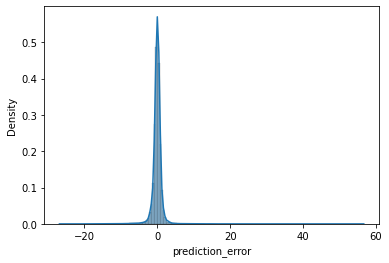

In [42]:
sns.histplot(x=preds_df_cull['prediction_error'], bins=200, kde=True, stat='density')


<AxesSubplot:xlabel='prediction_error'>

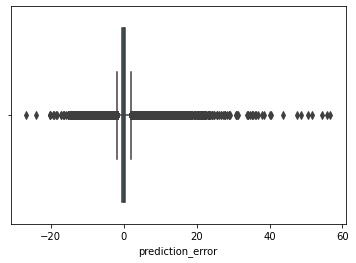

In [43]:
sns.boxplot(x=preds_df_cull['prediction_error'])
#sns.boxplot(x=preds_df_cull['fare_amount'])

Predictions vs true fare amounts distributions

In [44]:
import matplotlib.pyplot as plt

In [45]:
(preds_df_cull['prediction_error'] <= 0).describe()

count     132276
unique         2
top         True
freq       71245
Name: prediction_error, dtype: object

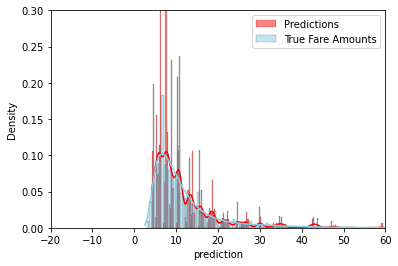

In [46]:
sns.histplot(x=preds_df_cull['prediction'],  bins=200, kde=True, stat='density', color="red", label="Predictions")
sns.histplot(x=preds_df_cull['fare_amount'],  bins=200, kde=True, stat='density', color="skyblue", label="True Fare Amounts")
plt.legend()
plt.xlim(-20, 60)
plt.ylim(0, 0.3)
#plt.show()
plt.savefig('../plots/preds_vs_true.png', dpi=300)

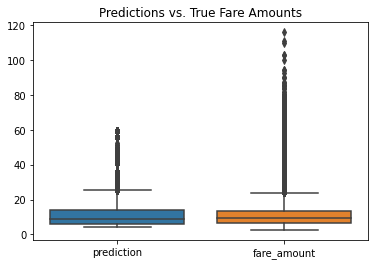

In [47]:
preds_boxplot_df = preds_df_cull[['prediction', 'fare_amount']]
preds_vs_fare = sns.boxplot(data=preds_boxplot_df)
plt.title("Predictions vs. True Fare Amounts")
#plt.legend()
plt.savefig('../plots/preds_vs_fare_boxplot.png')

In [48]:
# suggests a transform may have been handy

In [ ]:
# suggests a transform may have been handy

In [54]:
model2.featureImportances(1)

AttributeError: 'PipelineModel' object has no attribute 'featureImportances'

### Old Stuff

In [ ]:
(train, test) = dff.randomSplit([0.8, 0.2])

In [ ]:
from pyspark.ml.regression import LinearRegression

In [ ]:
rfc = LinearRegression(featuresCol="features", labelCol="fare_amount", predictionCol = 'pred_fare_amount', maxIter=10, regParam=0.3, elasticNetParam=0.8, standardization=True)

In [ ]:
linearmodel = rfc.fit(train)